In [1]:
import pandas as pd

# Load training (FY24+FY25) and test (FY26)
train_df = pd.read_pickle("FY24FY25.pkl")
test_df  = pd.read_pickle("FY26.pkl")

print("✅ Train shape:", train_df.shape)
print("✅ Test shape:", test_df.shape)


✅ Train shape: (2707209, 24)
✅ Test shape: (278942, 24)


In [18]:
train_df.shape

(2707209, 18)

In [19]:
train_df.columns


Index(['Total Billed FYTD', 'Billed Fees FYTD', 'FYTD Collections',
       'FYTD Labor Costs', 'Charged Hours FYTD', 'ETD Total Collections',
       'AR Outstanding', 'Billed Expenses FYTD', 'Expenses FYTD',
       'EAF Reserve FYTD', 'MS', 'Engagement Sub Service Line', 'Client',
       'Location', 'Engagement Partner', 'Week', 'ANSR / Tech Revenue FYTD',
       'Year'],
      dtype='object')

In [2]:
# Select required columns
features = [
    'Total Billed FYTD', 'Billed Fees FYTD', 'FYTD Collections',
    'FYTD Labor Costs', 'Charged Hours FYTD', 'ETD Total Collections',
    'AR Outstanding', 'Billed Expenses FYTD', 'Expenses FYTD', 'EAF Reserve FYTD',
    'MS', 'Engagement Sub Service Line', 'Client', 'Location', 'Engagement Partner', 'Week'
]
target = 'ANSR / Tech Revenue FYTD'

# Filter columns
train_df = train_df[features + [target]].copy()
test_df  = test_df[features + [target]].copy()

print("Columns selected successfully.")


Columns selected successfully.


In [3]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ["MS", "Engagement Sub Service Line", "Client", "Location", "Engagement Partner"]

encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    all_values = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(all_values)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col]  = le.transform(test_df[col].astype(str))
    encoders[col] = le

print("✅ Categorical columns encoded successfully.")



✅ Categorical columns encoded successfully.


In [4]:
from sklearn.model_selection import train_test_split

X = train_df[features]
y = train_df[target]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"✅ Train samples: {len(X_train):,}, Validation samples: {len(X_valid):,}")


✅ Train samples: 2,165,767, Validation samples: 541,442


In [5]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.08,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [6]:
y_pred_val = xgb_model.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred_val))
r2 = r2_score(y_valid, y_pred_val)

print(f"✅ Validation RMSE: {rmse:,.2f}")
print(f"📈 R² Score: {r2:.4f}")


✅ Validation RMSE: 168,674.63
📈 R² Score: 0.9985


In [7]:
mask = ~test_df[target].isna()
X_test = test_df.loc[mask, features]
y_test = test_df.loc[mask, target]

y_pred_test = xgb_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print(f"✅ FY26 Test RMSE: {rmse_test:,.2f}")
print(f"📈 FY26 Test R²: {r2_test:.4f}")
print(f"📊 Samples used: {len(X_test):,}")


✅ FY26 Test RMSE: 497,539.75
📈 FY26 Test R²: 0.7644
📊 Samples used: 278,337


c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


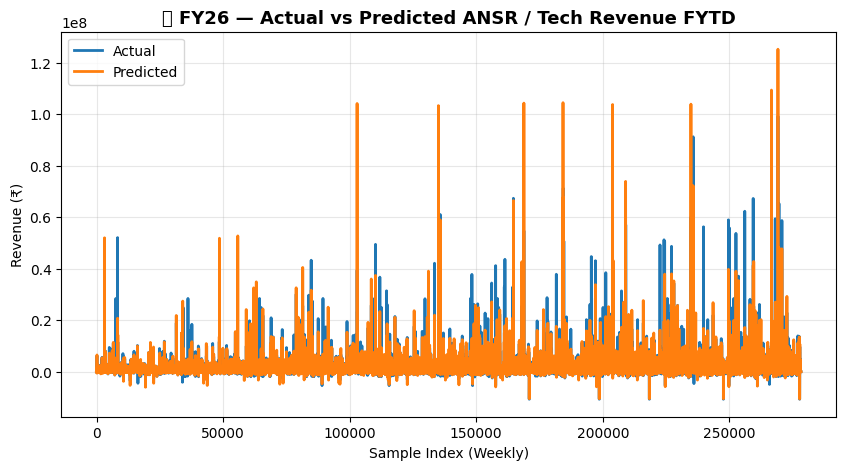

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual", color="#1f77b4", linewidth=2)
plt.plot(y_pred_test, label="Predicted", color="#ff7f0e", linewidth=2)
plt.title("📈 FY26 — Actual vs Predicted ANSR / Tech Revenue FYTD", fontsize=13, weight="bold")
plt.xlabel("Sample Index (Weekly)")
plt.ylabel("Revenue (₹)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [9]:
# Take latest week from FY26
latest_week = test_df["Week"].max()
base_data = test_df[test_df["Week"] == latest_week].copy()

future_weeks = list(range(latest_week + 1, latest_week + 13))
future_frames = []

for wk in future_weeks:
    temp = base_data.copy()
    temp["Week"] = wk
    future_frames.append(temp)

future_df = pd.concat(future_frames, ignore_index=True)

# Predict
X_future = future_df[features]
future_df["Predicted ANSR / Tech Revenue FYTD"] = xgb_model.predict(X_future)

print("✅ 12-week forecast completed!")
print(future_df[["Week", "Predicted ANSR / Tech Revenue FYTD"]].head(12))


✅ 12-week forecast completed!
    Week  Predicted ANSR / Tech Revenue FYTD
0     14                         -895.116577
1     14                      -397542.625000
2     14                      -133644.109375
3     14                         -895.116577
4     14                        -1005.510742
5     14                        -1610.911377
6     14                        -1492.186279
7     14                        -1610.911377
8     14                          230.521576
9     14                        -2990.296387
10    14                         2915.554688
11    14                        -2990.296387


C:\Users\FV586VH\AppData\Local\Temp\ipykernel_3324\2513622234.py:18: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


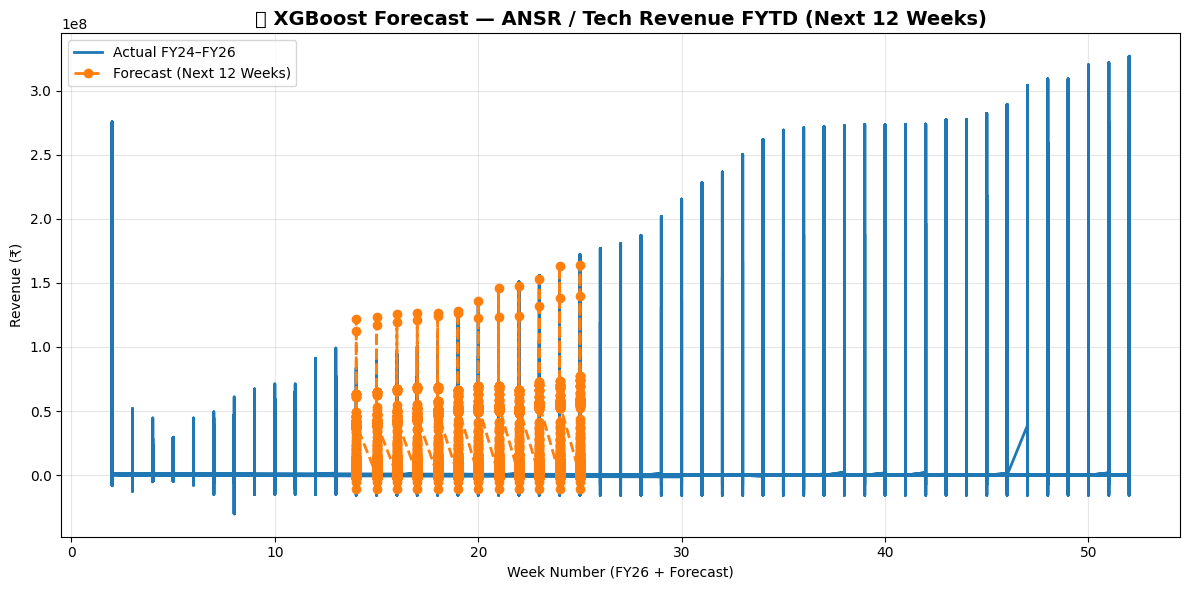

In [10]:
# Combine
historical = pd.concat([train_df, test_df], ignore_index=True)
historical["DataType"] = "Actual"
future_df["DataType"] = "Predicted"

combined = pd.concat([historical, future_df], ignore_index=True)

plt.figure(figsize=(12,6))
plt.plot(historical["Week"], historical[target], color="#1f77b4", label="Actual FY24–FY26", linewidth=2)
plt.plot(future_df["Week"], future_df["Predicted ANSR / Tech Revenue FYTD"],
         color="#ff7f0e", linestyle="--", marker="o", linewidth=2, label="Forecast (Next 12 Weeks)")

plt.title("📈 XGBoost Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)", fontsize=14, weight="bold")
plt.xlabel("Week Number (FY26 + Forecast)")
plt.ylabel("Revenue (₹)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\FV586VH\AppData\Local\Temp\ipykernel_3324\566792327.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\FV586VH\AppData\Local\Temp\ipykernel_3324\566792327.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


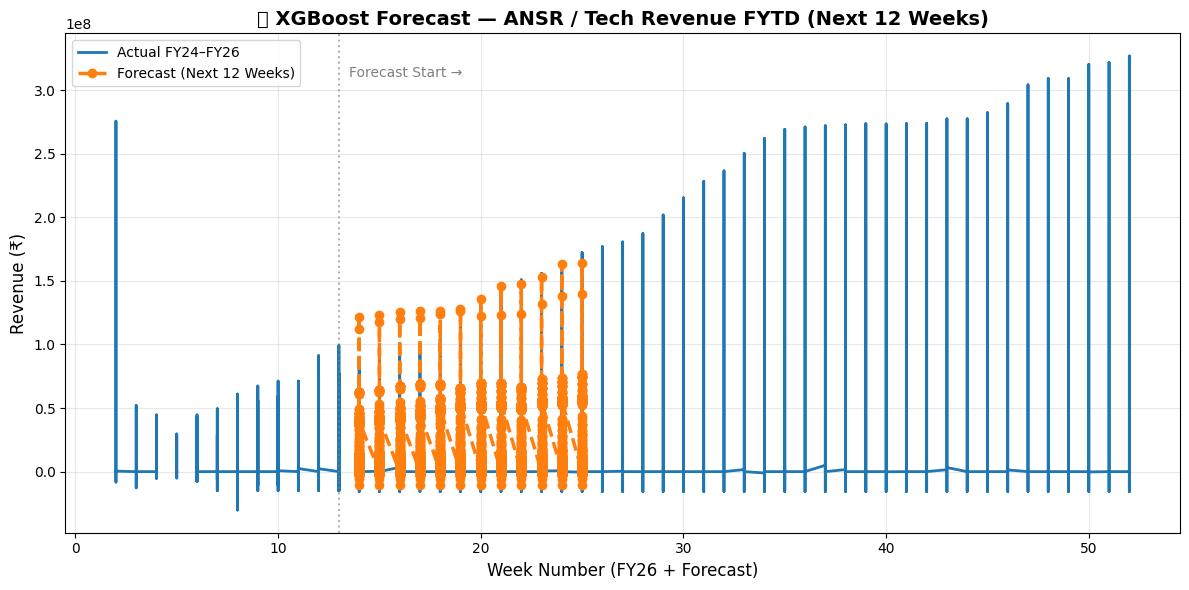

In [11]:
import matplotlib.pyplot as plt

# Sort data properly
historical = pd.concat([train_df, test_df], ignore_index=True)
historical = historical.sort_values("Week")

plt.figure(figsize=(12,6))

# Actual historical values
plt.plot(
    historical["Week"], historical["ANSR / Tech Revenue FYTD"],
    color="#1f77b4", linewidth=2, label="Actual FY24–FY26"
)

# Predicted future values
plt.plot(
    future_df["Week"], future_df["Predicted ANSR / Tech Revenue FYTD"],
    color="#ff7f0e", linestyle="--", linewidth=2.5, marker="o",
    label="Forecast (Next 12 Weeks)"
)

# Formatting
plt.title("📈 XGBoost Forecast — ANSR / Tech Revenue FYTD (Next 12 Weeks)", fontsize=14, weight="bold")
plt.xlabel("Week Number (FY26 + Forecast)", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True)
plt.grid(alpha=0.3)

# Highlight forecast start
cutoff_week = test_df["Week"].max()
plt.axvline(x=cutoff_week, color="gray", linestyle=":", alpha=0.6)
plt.text(cutoff_week + 0.5, plt.ylim()[1]*0.9, "Forecast Start →", color="gray", fontsize=10)

plt.tight_layout()
plt.show()


In [12]:
# Convert to weekly aggregates
weekly_actual = (
    test_df.groupby("Week", as_index=False)["ANSR / Tech Revenue FYTD"].mean()
)
weekly_forecast = (
    future_df.groupby("Week", as_index=False)["Predicted ANSR / Tech Revenue FYTD"].mean()
)

print("✅ Weekly aggregated actual:", weekly_actual.shape)
print("✅ Weekly aggregated forecast:", weekly_forecast.shape)

✅ Weekly aggregated actual: (11, 2)
✅ Weekly aggregated forecast: (12, 2)


C:\Users\FV586VH\AppData\Local\Temp\ipykernel_3324\1718675220.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


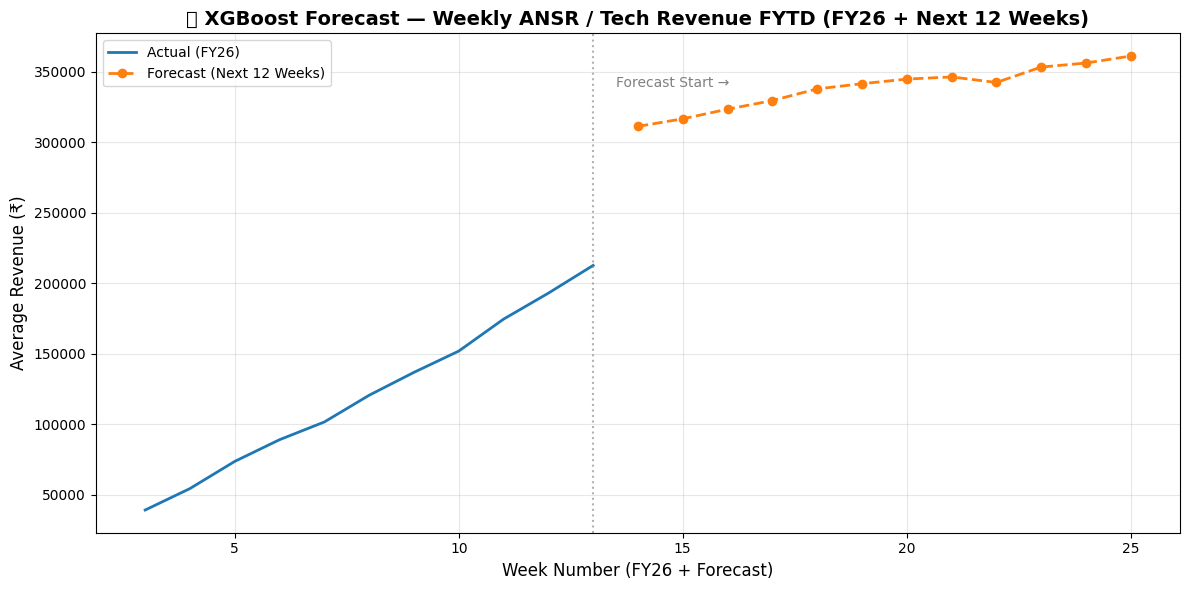

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot historical line
plt.plot(
    weekly_actual["Week"], weekly_actual["ANSR / Tech Revenue FYTD"],
    color="#1f77b4", linewidth=2, label="Actual (FY26)"
)

# Forecast line
plt.plot(
    weekly_forecast["Week"], weekly_forecast["Predicted ANSR / Tech Revenue FYTD"],
    color="#ff7f0e", linestyle="--", marker="o", linewidth=2,
    label="Forecast (Next 12 Weeks)"
)

# Mark the forecast start
cutoff_week = weekly_actual["Week"].max()
plt.axvline(x=cutoff_week, color="gray", linestyle=":", alpha=0.6)
plt.text(cutoff_week + 0.5, plt.ylim()[1]*0.9, "Forecast Start →", color="gray", fontsize=10)

plt.title("📈 XGBoost Forecast — Weekly ANSR / Tech Revenue FYTD (FY26 + Next 12 Weeks)", fontsize=14, weight="bold")
plt.xlabel("Week Number (FY26 + Forecast)", fontsize=12)
plt.ylabel("Average Revenue (₹)", fontsize=12)
plt.legend(frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\FV586VH\AppData\Local\Temp\ipykernel_3324\3146946491.py:66: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


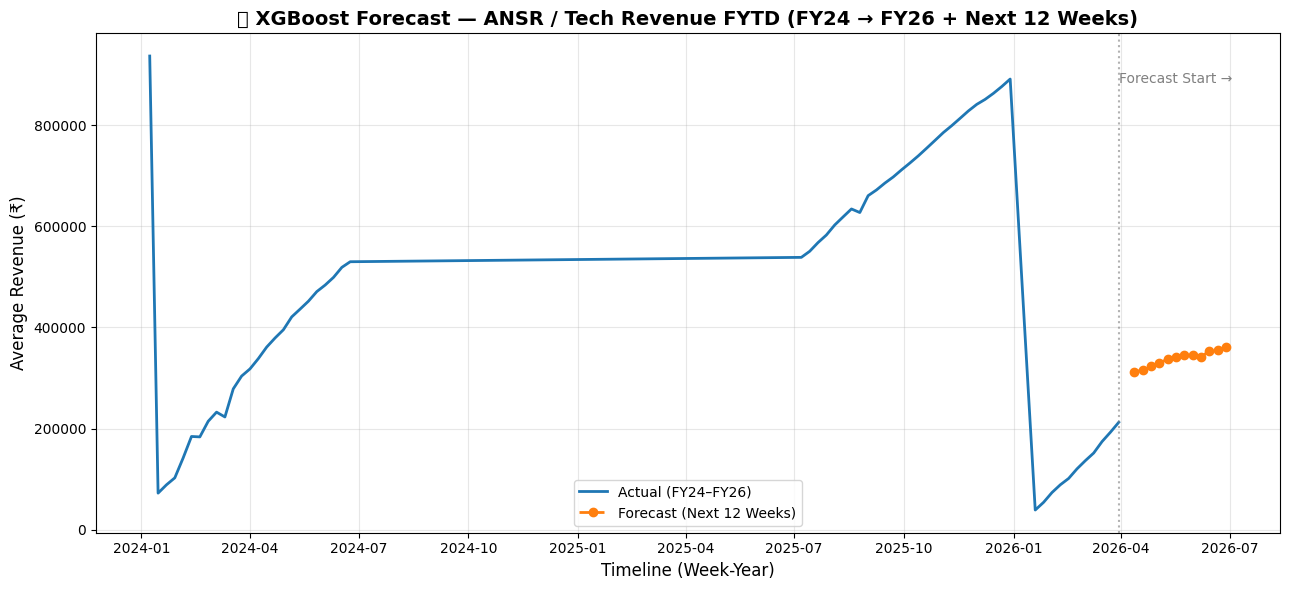

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Combine all years (FY24–FY26) ---
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Keep only needed columns
combined_df = combined_df[["Year", "Week", "ANSR / Tech Revenue FYTD"]]

# Create a numeric year (FY24 → 2024, etc.)
combined_df["Year_Num"] = combined_df["Year"].str.extract(r'(\d+)').astype(float) + 2000

# Drop NaNs safely
combined_df = combined_df.dropna(subset=["Year_Num", "Week"])

# Create date column (Monday of each week)
combined_df["Date"] = pd.to_datetime(
    combined_df["Year_Num"].astype(int).astype(str) + combined_df["Week"].astype(int).astype(str) + '1',
    format="%Y%W%w",
    errors="coerce"
)

# Aggregate weekly
weekly_actual = (
    combined_df.groupby("Date", as_index=False)["ANSR / Tech Revenue FYTD"].mean()
)

# --- Step 2: Forecast data aggregation ---
weekly_forecast = (
    future_df.groupby("Week", as_index=False)["Predicted ANSR / Tech Revenue FYTD"].mean()
)

# Extend the timeline for forecast
latest_date = weekly_actual["Date"].max()
future_dates = pd.date_range(start=latest_date, periods=len(weekly_forecast)+1, freq='W')[1:]
weekly_forecast["Date"] = future_dates

# --- Step 3: Plot ---
plt.figure(figsize=(13,6))

# Actual historical trend (FY24–FY26)
plt.plot(
    weekly_actual["Date"], weekly_actual["ANSR / Tech Revenue FYTD"],
    color="#1f77b4", linewidth=2, label="Actual (FY24–FY26)"
)

# Forecast line
plt.plot(
    weekly_forecast["Date"], weekly_forecast["Predicted ANSR / Tech Revenue FYTD"],
    color="#ff7f0e", linestyle="--", marker="o", linewidth=2,
    label="Forecast (Next 12 Weeks)"
)

# Formatting
plt.title("📈 XGBoost Forecast — ANSR / Tech Revenue FYTD (FY24 → FY26 + Next 12 Weeks)", fontsize=14, weight="bold")
plt.xlabel("Timeline (Week-Year)", fontsize=12)
plt.ylabel("Average Revenue (₹)", fontsize=12)
plt.legend(frameon=True)
plt.grid(alpha=0.3)

# Mark forecast start
cutoff_date = weekly_actual["Date"].max()
plt.axvline(x=cutoff_date, color="gray", linestyle=":", alpha=0.6)
plt.text(cutoff_date, plt.ylim()[1]*0.9, "Forecast Start →", color="gray", fontsize=10)

plt.tight_layout()
plt.show()


In [15]:
print("Train columns:", train_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())


Train columns: ['Total Billed FYTD', 'Billed Fees FYTD', 'FYTD Collections', 'FYTD Labor Costs', 'Charged Hours FYTD', 'ETD Total Collections', 'AR Outstanding', 'Billed Expenses FYTD', 'Expenses FYTD', 'EAF Reserve FYTD', 'MS', 'Engagement Sub Service Line', 'Client', 'Location', 'Engagement Partner', 'Week', 'ANSR / Tech Revenue FYTD']
Test columns: ['Total Billed FYTD', 'Billed Fees FYTD', 'FYTD Collections', 'FYTD Labor Costs', 'Charged Hours FYTD', 'ETD Total Collections', 'AR Outstanding', 'Billed Expenses FYTD', 'Expenses FYTD', 'EAF Reserve FYTD', 'MS', 'Engagement Sub Service Line', 'Client', 'Location', 'Engagement Partner', 'Week', 'ANSR / Tech Revenue FYTD']


In [16]:
# Add Year information
train_df["Year"] = "FY24FY25"
test_df["Year"] = "FY26"

# (Optional) Split train into FY24 and FY25 based on week number if you want separate years
train_df.loc[train_df["Week"] <= 26, "Year"] = "FY24"
train_df.loc[train_df["Week"] > 26, "Year"] = "FY25"



📊 XGBoost Model Performance — Validation Set
   RMSE   : 168,674.63
   MAE    : 46,031.46
   MAPE   : 81253543025126.77%
   R²     : 0.9985
   Accuracy (≈ 100 - MAPE): 0.00%

📊 XGBoost Model Performance — FY26 Test Set
   RMSE   : 497,539.75
   MAE    : 30,616.23
   MAPE   : 280357579157992.81%
   R²     : 0.7644
   Accuracy (≈ 100 - MAPE): 0.00%


C:\Users\FV586VH\AppData\Local\Temp\ipykernel_3324\683974892.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


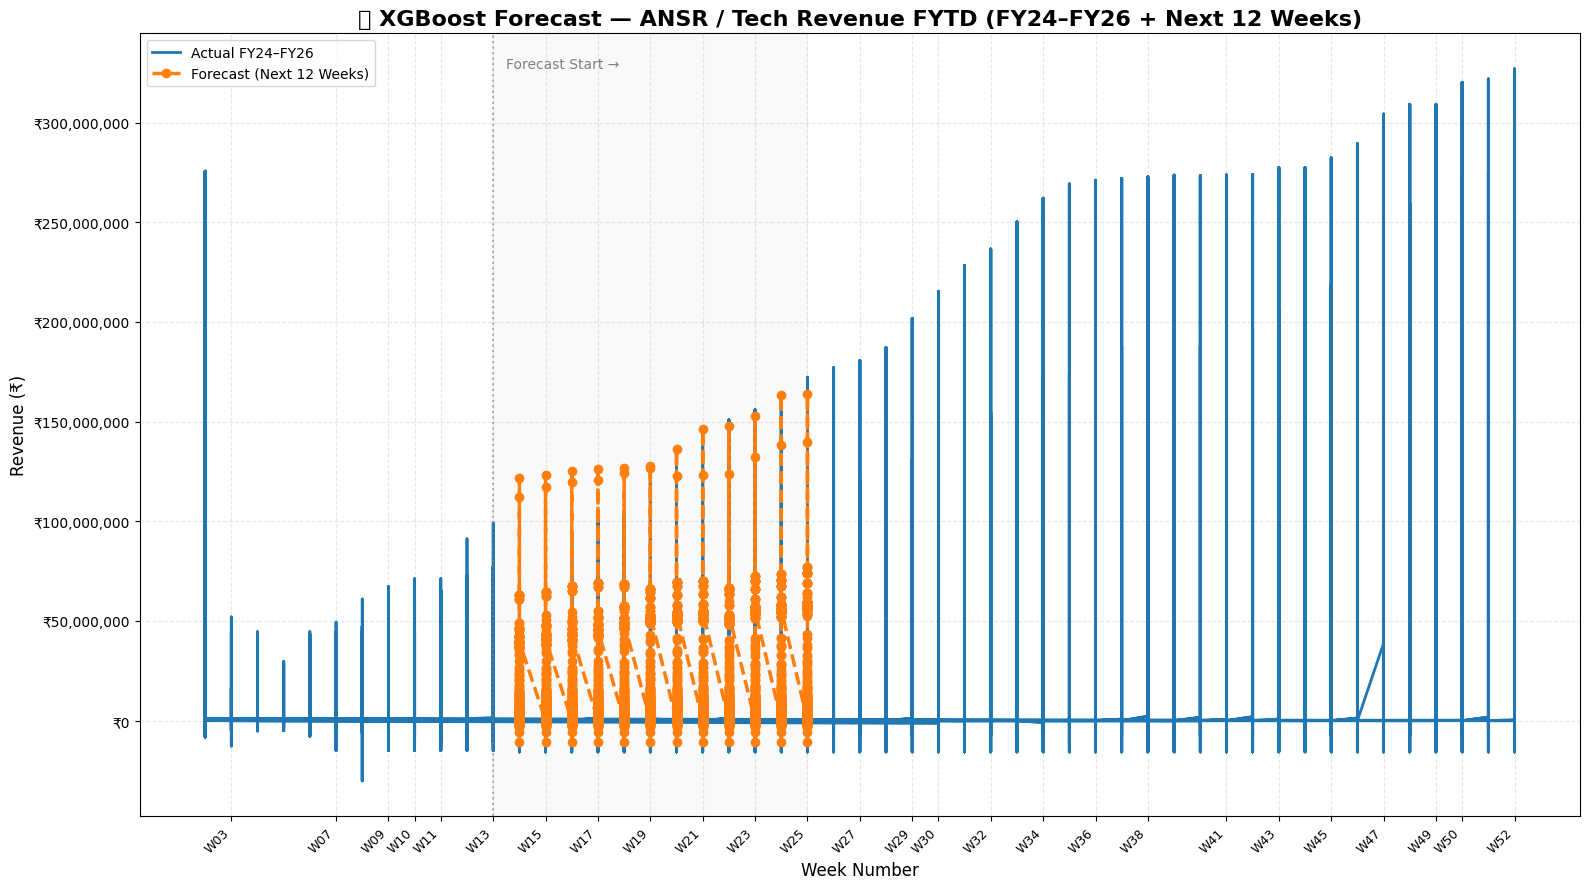


📅 Next 12 Weeks Forecast:


,Week,Predicted ANSR / Tech Revenue FYTD
0,14,-895.116577
1,14,-397542.625000
2,14,-133644.109375
3,14,-895.116577
4,14,-1005.510742
5,14,-1610.911377
6,14,-1492.186279
7,14,-1610.911377
8,14,230.521576
9,14,-2990.296387


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# === 1️⃣ Load & Prepare Data ===
train_df = pd.read_pickle("FY24FY25.pkl")
test_df  = pd.read_pickle("FY26.pkl")

features = [
    'Total Billed FYTD', 'Billed Fees FYTD', 'FYTD Collections',
    'FYTD Labor Costs', 'Charged Hours FYTD', 'ETD Total Collections',
    'AR Outstanding', 'Billed Expenses FYTD', 'Expenses FYTD', 'EAF Reserve FYTD',
    'MS', 'Engagement Sub Service Line', 'Client', 'Location', 'Engagement Partner', 'Week'
]
target = 'ANSR / Tech Revenue FYTD'

train_df = train_df[features + [target]].copy()
test_df  = test_df[features + [target]].copy()

# === 2️⃣ Encode Categorical Columns ===
cat_cols = ["MS", "Engagement Sub Service Line", "Client", "Location", "Engagement Partner"]
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    all_values = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(all_values)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col]  = le.transform(test_df[col].astype(str))
    encoders[col] = le

# === 3️⃣ Train / Validation Split ===
X = train_df[features]
y = train_df[target]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

# === 4️⃣ Train XGBoost Model ===
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.08,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# === 5️⃣ Evaluate on Validation Data ===
y_pred_val = xgb_model.predict(X_valid)
rmse_val = np.sqrt(mean_squared_error(y_valid, y_pred_val))
mae_val = mean_absolute_error(y_valid, y_pred_val)
mape_val = np.mean(np.abs((y_valid - y_pred_val) / np.maximum(np.abs(y_valid), 1e-9))) * 100
r2_val = r2_score(y_valid, y_pred_val)
accuracy_val = max(0, 100 - mape_val)

print("\n📊 XGBoost Model Performance — Validation Set")
print(f"   RMSE   : {rmse_val:,.2f}")
print(f"   MAE    : {mae_val:,.2f}")
print(f"   MAPE   : {mape_val:.2f}%")
print(f"   R²     : {r2_val:.4f}")
print(f"   Accuracy (≈ 100 - MAPE): {accuracy_val:.2f}%")

# === 6️⃣ Evaluate on FY26 Test Data ===
mask = ~test_df[target].isna()
X_test = test_df.loc[mask, features]
y_test = test_df.loc[mask, target]
y_pred_test = xgb_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / np.maximum(np.abs(y_test), 1e-9))) * 100
r2_test = r2_score(y_test, y_pred_test)
accuracy_test = max(0, 100 - mape_test)

print("\n📊 XGBoost Model Performance — FY26 Test Set")
print(f"   RMSE   : {rmse_test:,.2f}")
print(f"   MAE    : {mae_test:,.2f}")
print(f"   MAPE   : {mape_test:.2f}%")
print(f"   R²     : {r2_test:.4f}")
print(f"   Accuracy (≈ 100 - MAPE): {accuracy_test:.2f}%")

# === 7️⃣ Forecast Next 12 Weeks ===
latest_week = test_df["Week"].max()
base_data = test_df[test_df["Week"] == latest_week].copy()

future_weeks = list(range(latest_week + 1, latest_week + 13))
future_frames = []
for wk in future_weeks:
    temp = base_data.copy()
    temp["Week"] = wk
    future_frames.append(temp)

future_df = pd.concat(future_frames, ignore_index=True)
X_future = future_df[features]
future_df["Predicted ANSR / Tech Revenue FYTD"] = xgb_model.predict(X_future)

# === 8️⃣ Combine Historical + Forecast ===
historical = pd.concat([train_df, test_df], ignore_index=True)
historical["DataType"] = "Actual"
future_df["DataType"] = "Predicted"
combined = pd.concat([historical, future_df], ignore_index=True)

# === 9️⃣ Create Timeline Axis ===
combined["Year"] = np.select(
    [combined["Week"] <= 26, combined["Week"] > 26],
    ["FY24", "FY25"],
    default="FY26"
)

# Create simple week labels for X-axis
tick_weeks = combined["Week"].unique()[::2]
week_labels = [f"W{int(w):02d}" for w in tick_weeks]

# === 🔟 Plot Forecast ===
plt.figure(figsize=(16, 9))

# Plot Actual
plt.plot(
    combined[combined["DataType"] == "Actual"]["Week"],
    combined[combined["DataType"] == "Actual"]["ANSR / Tech Revenue FYTD"],
    color="#1f77b4", linewidth=2, label="Actual FY24–FY26"
)

# Plot Forecast
plt.plot(
    future_df["Week"], future_df["Predicted ANSR / Tech Revenue FYTD"],
    color="#ff7f0e", linestyle="--", marker="o", linewidth=2.5,
    label="Forecast (Next 12 Weeks)"
)

# Highlight forecast region
cutoff_week = test_df["Week"].max()
plt.axvline(x=cutoff_week, color="gray", linestyle=":", alpha=0.6)
plt.axvspan(cutoff_week, future_df["Week"].max(), color="#f0f0f0", alpha=0.4)
plt.text(cutoff_week + 0.5, plt.ylim()[1]*0.95, "Forecast Start →", color="gray", fontsize=10)

# X-axis formatting
plt.xticks(ticks=tick_weeks, labels=week_labels, rotation=45, ha="right", fontsize=9)

# Y-axis formatting
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"₹{x:,.0f}"))

# Titles & labels
plt.title("📈 XGBoost Forecast — ANSR / Tech Revenue FYTD (FY24–FY26 + Next 12 Weeks)", fontsize=16, weight="bold")
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# === 1️⃣1️⃣ Show 12-week forecast values ===
print("\n📅 Next 12 Weeks Forecast:")
display(future_df[["Week", "Predicted ANSR / Tech Revenue FYTD"]].head(12))


In [37]:
train_df.shape

(2707209, 17)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# === 1️⃣ Load Data ===
train_df = pd.read_pickle("FY24FY25.pkl")
test_df  = pd.read_pickle("FY26.pkl")

features = [
    'Total Billed FYTD', 'Billed Fees FYTD', 'FYTD Collections',
    'FYTD Labor Costs', 'Charged Hours FYTD', 'ETD Total Collections',
    'AR Outstanding', 'Billed Expenses FYTD', 'Expenses FYTD', 'EAF Reserve FYTD',
    'MS', 'Engagement Sub Service Line', 'Client', 'Location', 'Engagement Partner', 'Week'
]
target = 'ANSR / Tech Revenue FYTD'

train_df = train_df[features + [target]].copy()
test_df  = test_df[features + [target]].copy()

# === 2️⃣ Encode Categorical Columns ===
cat_cols = ["MS", "Engagement Sub Service Line", "Client", "Location", "Engagement Partner"]
for col in cat_cols:
    le = LabelEncoder()
    all_values = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(all_values)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col]  = le.transform(test_df[col].astype(str))

# === 3️⃣ Add Fiscal Year Labels ===
train_df["Year"] = np.where(train_df["Week"] <= 26, "FY24", "FY25")
test_df["Year"] = "FY26"

# === 4️⃣ Train / Validation Split ===
X = train_df[features]
y = train_df[target]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

# === 5️⃣ Train Model ===
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.08,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# === 6️⃣ Evaluate Model Performance ===
def evaluate_model(y_true, y_pred, label=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-9))) * 100
    r2 = r2_score(y_true, y_pred)
    acc = max(0, 100 - mape)
    print(f"\n📊 XGBoost {label} Performance")
    print(f"   RMSE   : {rmse:,.2f}")
    print(f"   MAE    : {mae:,.2f}")
    print(f"   MAPE   : {mape:.2f}%")
    print(f"   R²     : {r2:.4f}")
    print(f"   Accuracy (≈ 100 - MAPE): {acc:.2f}%")
    return rmse, mae, mape, r2, acc

# Validation
y_pred_val = xgb_model.predict(X_valid)
evaluate_model(y_valid, y_pred_val, "Validation Set")

# Test FY26
mask = ~test_df[target].isna()
X_test = test_df.loc[mask, features]
y_test = test_df.loc[mask, target]
y_pred_test = xgb_model.predict(X_test)
evaluate_model(y_test, y_pred_test, "FY26 Test Set")

# === 7️⃣ Forecast Next 12 Weeks ===
latest_week = test_df["Week"].max()
base_data = test_df[test_df["Week"] == latest_week].copy()
future_weeks = list(range(latest_week + 1, latest_week + 13))
future_frames = []

for wk in future_weeks:
    temp = base_data.copy()
    temp["Week"] = wk
    temp["Year"] = "Forecast"
    future_frames.append(temp)

future_df = pd.concat(future_frames, ignore_index=True)
future_df["Predicted ANSR / Tech Revenue FYTD"] = xgb_model.predict(future_df[features])

# === 8️⃣ Create Continuous Timeline ===
combined = pd.concat([train_df, test_df, future_df], ignore_index=True)
combined["Year_Num"] = combined["Year"].replace({"FY24": 2024, "FY25": 2025, "FY26": 2026, "Forecast": 2027})
combined["Date"] = pd.to_datetime(
    combined["Year_Num"].astype(str) + combined["Week"].astype(str) + "1",
    format="%Y%W%w",
    errors="coerce"
)
combined = combined.sort_values("Date")

# === 9️⃣ Plot Continuous Line Chart ===
plt.figure(figsize=(16, 9))

# Actual
plt.plot(
    combined[combined["Year"] != "Forecast"]["Date"],
    combined[combined["Year"] != "Forecast"]["ANSR / Tech Revenue FYTD"],
    color="#1f77b4", linewidth=2, label="Actual FY24–FY26"
)

# Forecast
plt.plot(
    combined[combined["Year"] == "Forecast"]["Date"],
    combined[combined["Year"] == "Forecast"]["Predicted ANSR / Tech Revenue FYTD"],
    color="#ff7f0e", linestyle="--", linewidth=2.5, marker="o", label="Forecast (Next 12 Weeks)"
)

# Highlight forecast region
cutoff_date = combined[combined["Year"] == "FY26"]["Date"].max()
plt.axvline(x=cutoff_date, color="gray", linestyle=":", alpha=0.7)
plt.axvspan(cutoff_date, combined["Date"].max(), color="#f0f0f0", alpha=0.4)
plt.text(cutoff_date, plt.ylim()[1]*0.95, "Forecast Start →", color="gray", fontsize=10)

# Mark FY start indicators
for fy in ["FY24", "FY25", "FY26"]:
    fy_start = combined[combined["Year"] == fy]["Date"].min()
    plt.axvline(x=fy_start, color="gray", linestyle=":", alpha=0.4)
    plt.text(fy_start, plt.ylim()[1]*0.9, f"{fy} Start →", color="gray", fontsize=9)

# X-axis formatting (every 2 weeks)
tick_idx = combined["Date"].iloc[::2]
tick_labels = [f"W{d.isocalendar().week:02d}" for d in tick_idx]
plt.xticks(ticks=tick_idx, labels=tick_labels, rotation=45, ha="right", fontsize=9)

# Y-axis formatting
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"₹{x:,.0f}"))

# Titles & labels
plt.title("📈 XGBoost Forecast — ANSR / Tech Revenue FYTD (FY24–FY26 + Next 12 Weeks)", fontsize=16, weight="bold", pad=15)
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# === 🔟 Show Forecast Table ===
display(future_df[["Week", "Predicted ANSR / Tech Revenue FYTD"]].head(12))



📊 XGBoost Validation Set Performance
   RMSE   : 168,674.63
   MAE    : 46,031.46
   MAPE   : 81253543025126.77%
   R²     : 0.9985
   Accuracy (≈ 100 - MAPE): 0.00%

📊 XGBoost FY26 Test Set Performance
   RMSE   : 497,539.75
   MAE    : 30,616.23
   MAPE   : 280357579157992.81%
   R²     : 0.7644
   Accuracy (≈ 100 - MAPE): 0.00%


C:\Users\FV586VH\AppData\Local\Temp\ipykernel_34332\2372049655.py:96: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined["Year_Num"] = combined["Year"].replace({"FY24": 2024, "FY25": 2025, "FY26": 2026, "Forecast": 2027})



📊 XGBoost Model — Validation Performance
   RMSE : 168,674.63
   MAE  : 46,031.46
   MAPE : 81253543025126.77%
   R²   : 0.9985
   Accuracy ≈ 0.00%

📊 XGBoost Model — FY26 Test Performance
   RMSE : 497,539.75
   MAE  : 30,616.23
   MAPE : 280357579157992.81%
   R²   : 0.7644
   Accuracy ≈ 0.00%


C:\Users\FV586VH\AppData\Local\Temp\ipykernel_27604\3929332456.py:145: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\FV586VH\Downloads\VSC\Model\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


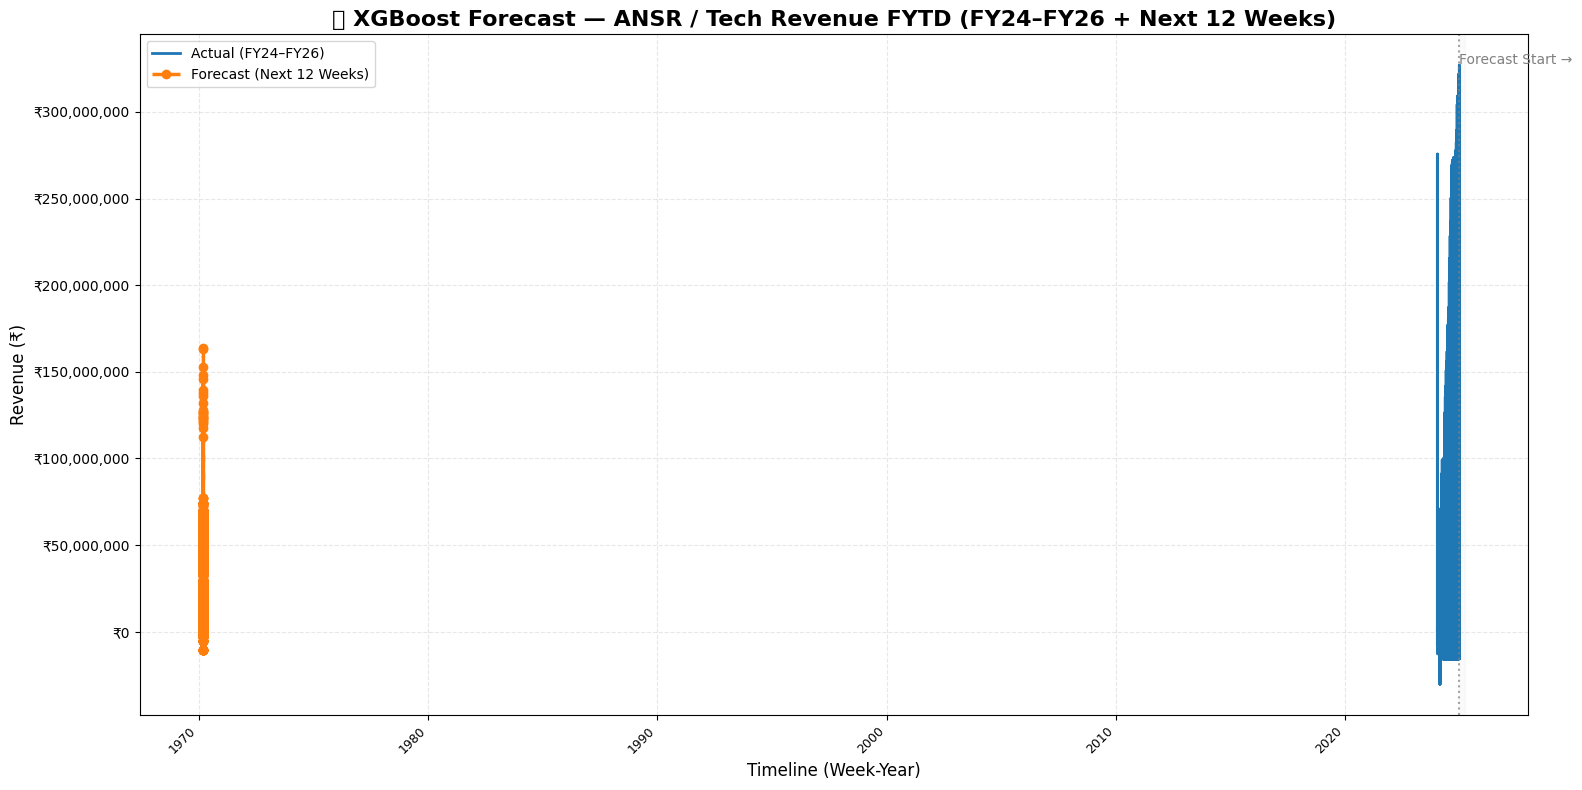


📅 Next 12 Weeks Forecast:


,Week,Predicted ANSR / Tech Revenue FYTD
0,14,-895.116577
1,14,-397542.625000
2,14,-133644.109375
3,14,-895.116577
4,14,-1005.510742
5,14,-1610.911377
6,14,-1492.186279
7,14,-1610.911377
8,14,230.521576
9,14,-2990.296387


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.ticker as mtick

# === 1️⃣ Load & Prepare Data ===
train_df = pd.read_pickle("FY24FY25.pkl")
test_df  = pd.read_pickle("FY26.pkl")

features = [
    'Total Billed FYTD', 'Billed Fees FYTD', 'FYTD Collections',
    'FYTD Labor Costs', 'Charged Hours FYTD', 'ETD Total Collections',
    'AR Outstanding', 'Billed Expenses FYTD', 'Expenses FYTD', 'EAF Reserve FYTD',
    'MS', 'Engagement Sub Service Line', 'Client', 'Location', 'Engagement Partner', 'Week'
]
target = 'ANSR / Tech Revenue FYTD'

train_df = train_df[features + [target]].copy()
test_df  = test_df[features + [target]].copy()

# === 2️⃣ Encode Categorical Columns ===
cat_cols = ["MS", "Engagement Sub Service Line", "Client", "Location", "Engagement Partner"]
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    all_values = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(all_values)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col]  = le.transform(test_df[col].astype(str))
    encoders[col] = le

# === 3️⃣ Train / Validation Split ===
X = train_df[features]
y = train_df[target]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

# === 4️⃣ Train XGBoost Model ===
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.08,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# === 5️⃣ Evaluate on Validation ===
y_pred_val = xgb_model.predict(X_valid)
rmse_val = np.sqrt(mean_squared_error(y_valid, y_pred_val))
mae_val = mean_absolute_error(y_valid, y_pred_val)
mape_val = np.mean(np.abs((y_valid - y_pred_val) / np.maximum(np.abs(y_valid), 1e-9))) * 100
r2_val = r2_score(y_valid, y_pred_val)

print("\n📊 XGBoost Model — Validation Performance")
print(f"   RMSE : {rmse_val:,.2f}")
print(f"   MAE  : {mae_val:,.2f}")
print(f"   MAPE : {mape_val:.2f}%")
print(f"   R²   : {r2_val:.4f}")
print(f"   Accuracy ≈ {max(0, 100 - mape_val):.2f}%")

# === 6️⃣ Evaluate on FY26 Test ===
mask = ~test_df[target].isna()
X_test = test_df.loc[mask, features]
y_test = test_df.loc[mask, target]
y_pred_test = xgb_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / np.maximum(np.abs(y_test), 1e-9))) * 100
r2_test = r2_score(y_test, y_pred_test)

print("\n📊 XGBoost Model — FY26 Test Performance")
print(f"   RMSE : {rmse_test:,.2f}")
print(f"   MAE  : {mae_test:,.2f}")
print(f"   MAPE : {mape_test:.2f}%")
print(f"   R²   : {r2_test:.4f}")
print(f"   Accuracy ≈ {max(0, 100 - mape_test):.2f}%")

# === 7️⃣ Forecast Next 12 Weeks ===
latest_week = test_df["Week"].max()
base_data = test_df[test_df["Week"] == latest_week].copy()

future_weeks = list(range(latest_week + 1, latest_week + 13))
future_frames = []
for wk in future_weeks:
    temp = base_data.copy()
    temp["Week"] = wk
    future_frames.append(temp)

future_df = pd.concat(future_frames, ignore_index=True)
X_future = future_df[features]
future_df["Predicted ANSR / Tech Revenue FYTD"] = xgb_model.predict(X_future)

# === 8️⃣ Combine Historical + Forecast ===
historical = pd.concat([train_df, test_df], ignore_index=True)
historical["DataType"] = "Actual"
future_df["DataType"] = "Predicted"

combined = pd.concat([historical, future_df], ignore_index=True)

# === 9️⃣ Create Continuous Timeline ===
combined["Year_Num"] = np.where(combined["Week"] <= 52, 2024, 2025)
combined["Date"] = pd.to_datetime(
    combined["Year_Num"].astype(str) + combined["Week"].astype(str) + "1",
    format="%Y%W%w", errors="coerce"
)
combined = combined.sort_values("Date")

# === 🔟 Plot ===
plt.figure(figsize=(16, 8))

# Actual (FY24–FY26)
plt.plot(
    combined[combined["DataType"] == "Actual"]["Date"],
    combined[combined["DataType"] == "Actual"]["ANSR / Tech Revenue FYTD"],
    color="#1f77b4", linewidth=2, label="Actual (FY24–FY26)"
)

# Forecast (Next 12 Weeks)
plt.plot(
    future_df["Week"] + combined["Week"].max(),  # continuous look
    future_df["Predicted ANSR / Tech Revenue FYTD"],
    color="#ff7f0e", linestyle="--", marker="o", linewidth=2.5, label="Forecast (Next 12 Weeks)"
)

# Shaded forecast region
cutoff_date = combined["Date"].max()
plt.axvline(x=cutoff_date, color="gray", linestyle=":", alpha=0.7)
plt.axvspan(cutoff_date, cutoff_date + pd.Timedelta(weeks=12), color="#f0f0f0", alpha=0.3)
plt.text(cutoff_date, plt.ylim()[1]*0.95, "Forecast Start →", color="gray", fontsize=10)

# Format axes
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.0f}'))
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.title("📈 XGBoost Forecast — ANSR / Tech Revenue FYTD (FY24–FY26 + Next 12 Weeks)", fontsize=16, weight="bold")
plt.xlabel("Timeline (Week-Year)", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# === 1️⃣1️⃣ Show Forecast ===
print("\n📅 Next 12 Weeks Forecast:")
display(future_df[["Week", "Predicted ANSR / Tech Revenue FYTD"]].head(12))


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings("ignore")

# === 1️⃣ Load & Prepare Data ===
train_df = pd.read_pickle("FY24FY25.pkl")
test_df  = pd.read_pickle("FY26.pkl")

features = [
    'Total Billed FYTD', 'Billed Fees FYTD', 'FYTD Collections',
    'FYTD Labor Costs', 'Charged Hours FYTD', 'ETD Total Collections',
    'AR Outstanding', 'Billed Expenses FYTD', 'Expenses FYTD', 'EAF Reserve FYTD',
    'MS', 'Engagement Sub Service Line', 'Client', 'Location', 'Engagement Partner', 'Week'
]
target = 'ANSR / Tech Revenue FYTD'

train_df = train_df[features + [target]].copy()
test_df  = test_df[features + [target]].copy()

# === 2️⃣ Encode Categorical Columns ===
cat_cols = ["MS", "Engagement Sub Service Line", "Client", "Location", "Engagement Partner"]
for col in cat_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train_df[col], test_df[col]]).astype(str))
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col]  = le.transform(test_df[col].astype(str))

# === 3️⃣ Train / Validation Split ===
X = train_df[features]
y = train_df[target]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

# === 4️⃣ Train Model ===
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.08,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# === 5️⃣ Evaluate Validation ===
y_pred_val = xgb_model.predict(X_valid)
rmse_val = np.sqrt(mean_squared_error(y_valid, y_pred_val))
mae_val = mean_absolute_error(y_valid, y_pred_val)
mape_val = np.mean(np.abs((y_valid - y_pred_val) / np.maximum(np.abs(y_valid), 1e-9))) * 100
r2_val = r2_score(y_valid, y_pred_val)

print("\n📊 XGBoost Model — Validation")
print(f"RMSE: {rmse_val:,.2f}")
print(f"MAE : {mae_val:,.2f}")
print(f"MAPE: {mape_val:.2f}%")
print(f"R²  : {r2_val:.4f}")
print(f"Accuracy ≈ {max(0, 100 - mape_val):.2f}%")

# === 6️⃣ Evaluate FY26 Test ===
mask = ~test_df[target].isna()
X_test = test_df.loc[mask, features]
y_test = test_df.loc[mask, target]
y_pred_test = xgb_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / np.maximum(np.abs(y_test), 1e-9))) * 100
r2_test = r2_score(y_test, y_pred_test)

print("\n📊 XGBoost Model — FY26 Test")
print(f"RMSE: {rmse_test:,.2f}")
print(f"MAE : {mae_test:,.2f}")
print(f"MAPE: {mape_test:.2f}%")
print(f"R²  : {r2_test:.4f}")
print(f"Accuracy ≈ {max(0, 100 - mape_test):.2f}%")

# === 7️⃣ Forecast Next 12 Weeks ===
latest_week = test_df["Week"].max()
base_data = test_df[test_df["Week"] == latest_week].copy()

future_weeks = list(range(latest_week + 1, latest_week + 13))
future_frames = []
for wk in future_weeks:
    temp = base_data.copy()
    temp["Week"] = wk
    future_frames.append(temp)

future_df = pd.concat(future_frames, ignore_index=True)
X_future = future_df[features]
future_df["Predicted ANSR / Tech Revenue FYTD"] = xgb_model.predict(X_future)

# === 8️⃣ Combine & Make Continuous Weekly Timeline ===
full_df = pd.concat([train_df, test_df], ignore_index=True)
full_df["Year"] = np.select(
    [full_df["Week"] <= 26, full_df["Week"] > 26],
    ["FY24", "FY25"],
    default="FY26"
)

full_df["Year_Num"] = full_df["Year"].str.extract(r"(\d+)").astype(float) + 2000
full_df["Date"] = pd.to_datetime(
    full_df["Year_Num"].astype(int).astype(str) + full_df["Week"].astype(int).astype(str) + "1",
    format="%Y%W%w", errors="coerce"
)
full_df = full_df.sort_values("Date")

latest_date = full_df["Date"].max()
future_dates = pd.date_range(start=latest_date + pd.Timedelta(days=7), periods=12, freq="W-MON")
future_df["Date"] = np.tile(future_dates, len(future_df) // len(future_dates))

# === 9️⃣ Plot ===
plt.figure(figsize=(15, 7))

plt.plot(
    full_df["Date"], full_df[target],
    color="#1f77b4", linewidth=2, label="Actual (FY24–FY26)"
)
plt.plot(
    future_df["Date"], future_df["Predicted ANSR / Tech Revenue FYTD"],
    color="#ff7f0e", linestyle="--", marker="o", linewidth=2.5,
    label="Forecast (Next 12 Weeks)"
)

# Forecast area
cutoff_date = full_df["Date"].max()
plt.axvline(x=cutoff_date, color="gray", linestyle=":", alpha=0.6)
plt.axvspan(cutoff_date, future_df["Date"].max(), color="#f0f0f0", alpha=0.3)
plt.text(cutoff_date, plt.ylim()[1]*0.95, "Forecast Start →", color="gray", fontsize=10)

# Format axes
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('₹{x:,.0f}'))
plt.xticks(ticks=full_df["Date"].iloc[::2], labels=[f"W{d.isocalendar().week:02d}" for d in full_df["Date"].iloc[::2]],
           rotation=45, ha="right", fontsize=8)

plt.title("📈 XGBoost Forecast — ANSR / Tech Revenue FYTD (FY24–FY26 + Next 12 Weeks)", fontsize=16, weight="bold")
plt.xlabel("Week Number", fontsize=12)
plt.ylabel("Revenue (₹)", fontsize=12)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# === 🔟 Display Forecast ===
print("\n📅 Next 12 Weeks Forecast:")
display(future_df[["Date", "Week", "Predicted ANSR / Tech Revenue FYTD"]].head(12))



📊 XGBoost Model — Validation
RMSE: 168,674.63
MAE : 46,031.46
MAPE: 81253543025126.77%
R²  : 0.9985
Accuracy ≈ 0.00%

📊 XGBoost Model — FY26 Test
RMSE: 497,539.75
MAE : 30,616.23
MAPE: 280357579157992.81%
R²  : 0.7644
Accuracy ≈ 0.00%


MemoryError: Unable to allocate 11.4 MiB for an array with shape (1, 1493076) and data type float64